In [ ]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using JLD

py"""
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
plt.rc('font', family='serif', serif=['Arial'])
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.titlesize'] = 10
"""

# modifiable parameters - Do we want to keep these or pre-select specific parameters for the workshop?
lam_list = [0.5, 1.0]
jj = 2

L_list = [6.0, 12.0]
ll = 1

Lffwd_list = [100, 150, 200, 250, 300, 350, 400]
oo = 5

wpffwd_list = [0.0, 1.0, 2.0]
pp = 1

fracTrained_list = vcat(collect(0.1:0.1:0.7), 1824/2500)
qq = 8 # Ntrained = Npyr


include("src_balanced/param.jl");


paramType(2000.0, 50, 0.05, 0.04, 0.04, 0.04, 0.04, 1.0, 8.0, 0.7296, 20.0, 200, 800.0, 1000.0, 3000.0, 0.1, 30000, 5000, 2500, 2500, 0.2, 0.2, 0.2, 0.2, 10.0, 10.0, 500, 22.360679774997898, 20, 300, 20, 20, 33.54101966249685, 0.8944271909999159, 0.8944271909999159, 2.6832815729997477, 0.13416407864998736, -0.6708203932499369, 0.8944271909999159, -0.8944271909999159, 0.5962847939999438, -0.3229875967499696, 0.5962847939999438, -0.3229875967499696, 0.0, 4.024922359499621, 4.024922359499621, 2.6832815729997477, 2.6832815729997477, 0.0, 1.0, 1.0, 0.1, 3.0, 3.0, 150.0, 500.0)

In [4]:
# run initial balanced network
include("src_balanced/genWeights.jl")
w0Index, w0Weights, nc0 = genWeights(p);

In [6]:
include("src_balanced/runinitial.jl")

times, ns0, uavg = runinitial(p, w0Index, w0Weights, nc0);


mean excitatory firing rate: 6.577120000000001 Hz
mean inhibitory firing rate: 11.93818 Hz


Select a fraction of the cells to train

In [7]:

Ntrained = 50

matchedCells = collect(1:Ntrained)
almOrd=matchedCells;

In [9]:
#select plastic weights to be trained
include("src_balanced/genPlasticWeights.jl")
include("src_balanced/convertWgtIn2Out.jl")


wpWeightFfwd, wpWeightIn, wpWeightOut, wpIndexIn, wpIndexOut, wpIndexConvert, ncpIn, ncpOut = genPlasticWeights(p, w0Index, nc0, ns0, matchedCells);


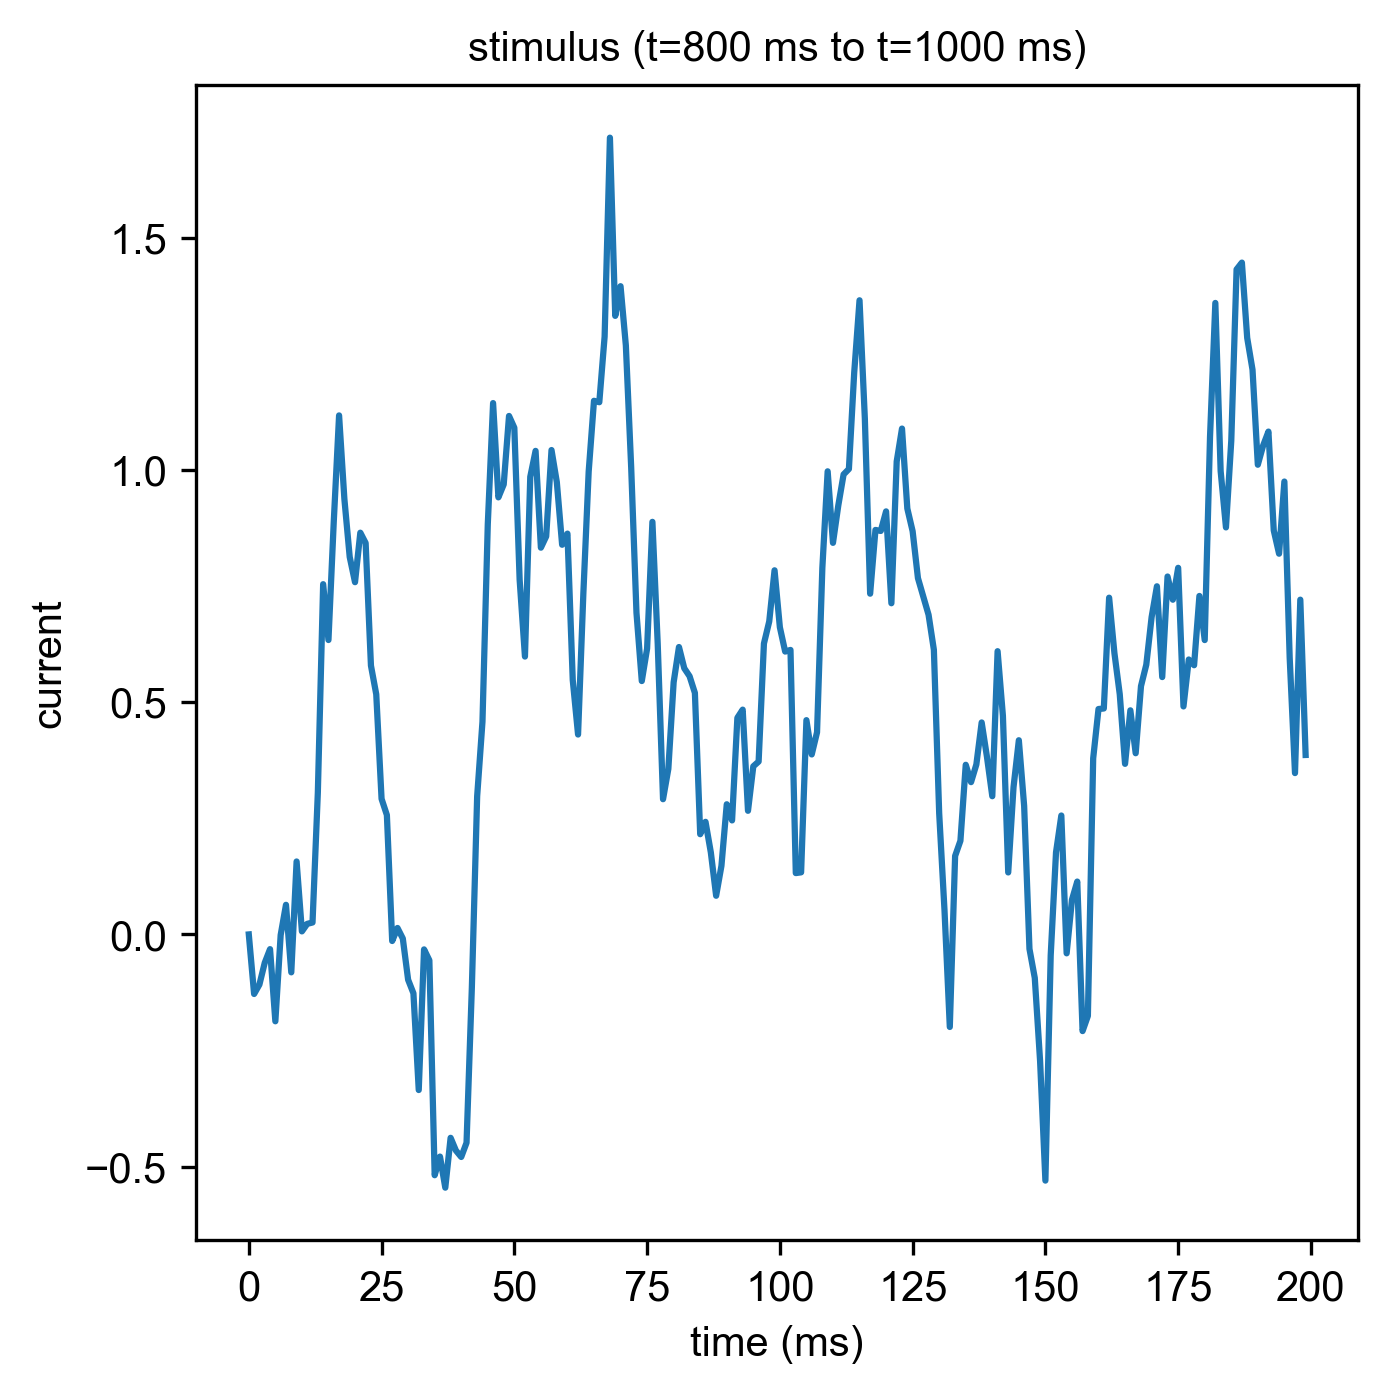

PyObject Text(0.5, 1.0, 'stimulus (t=800 ms to t=1000 ms)')

In [39]:
#Generate stimulus to trigger response
include("src_balanced/genStim.jl")

stim = Vector{Array{Float64,2}}()
stim_val = genStim(p)
push!(stim, stim_val);


plot(stim[1][1:10:end,500])

xlabel("time (ms)")
ylabel("current")
title("stimulus (t=800 ms to t=1000 ms)")


In [41]:
#Generate target data for training
function run_target(p, matchedCells)
    T = p.train_duration #should this be train_duration or train_time?
    t    = collect(dt:20:T);


    u_periodic  = zeros(length(t),p.Ncells);
    for j in matchedCells
        A = 5.0 #2.0
        T1 = 1000 #50, 1000
        t1 = T1*rand();
        u_periodic[:,j] = A*sin.((t.-t1)*(2*pi/T1)) .+ uavg[j]
            
     
    end
    return u_periodic

end

xtarg = Vector{Array{Float64,2}}()

#Generate target input
utarg = run_target(p, matchedCells)
push!(xtarg,utarg);


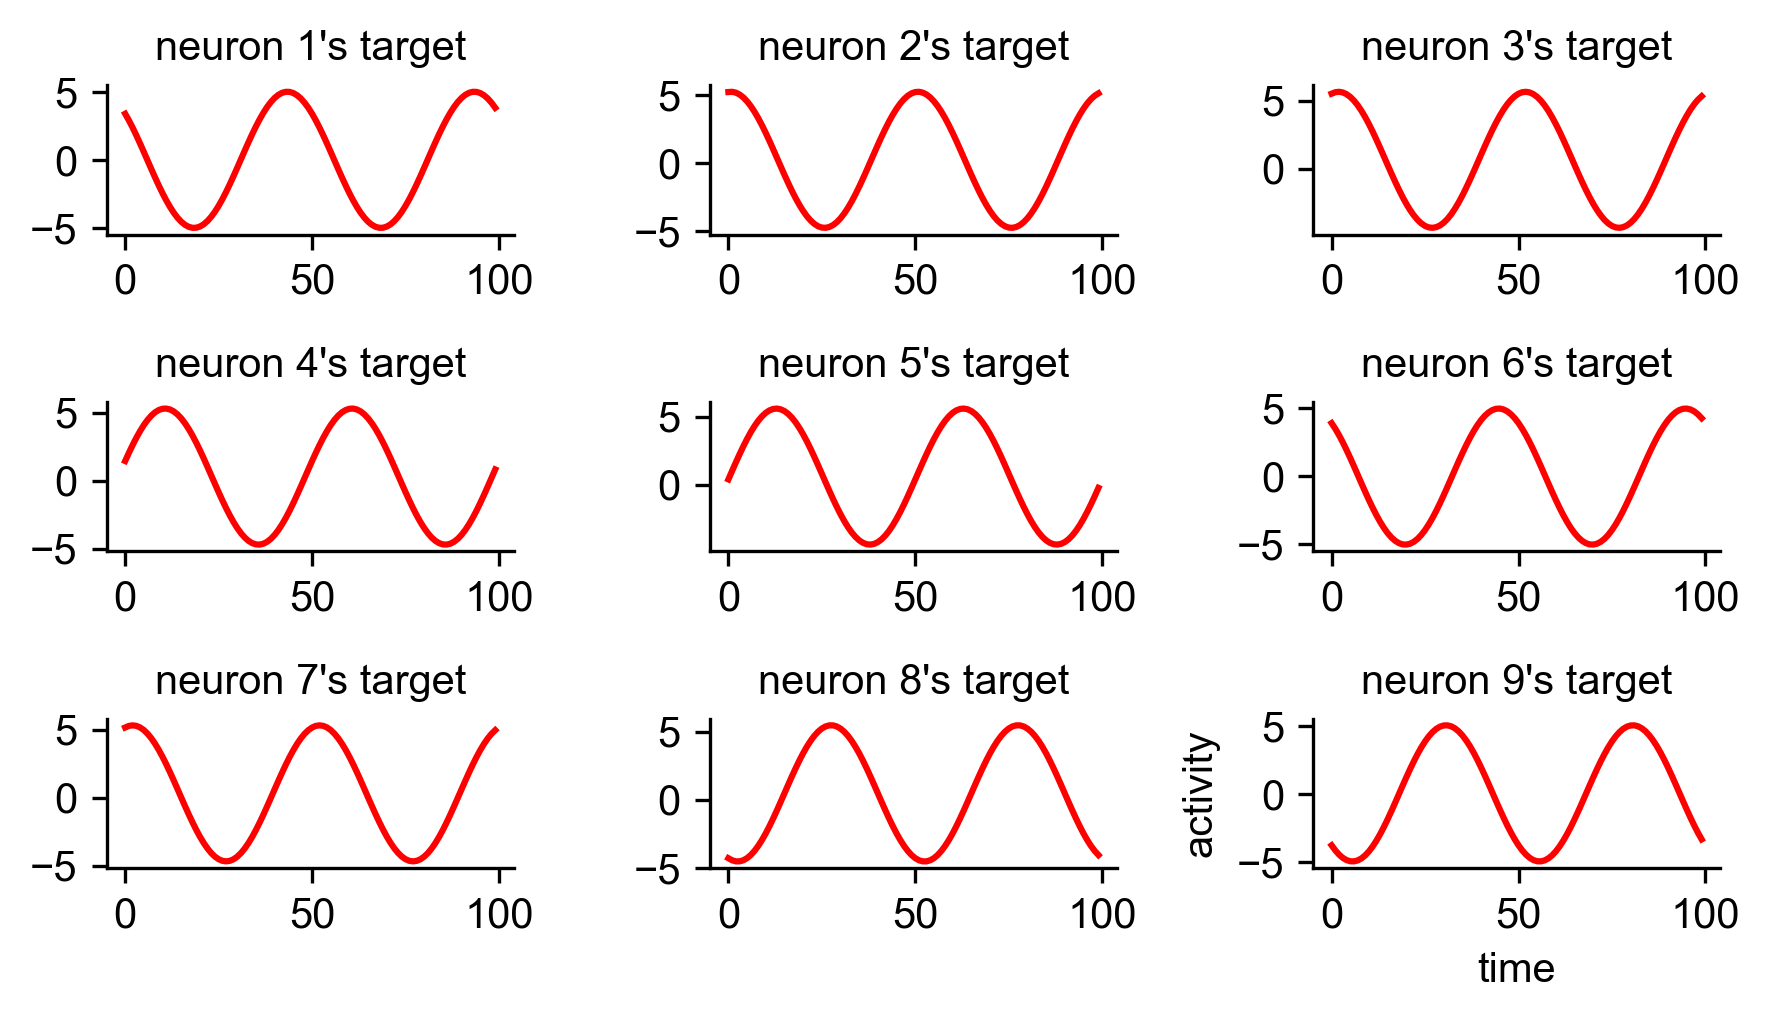

In [43]:
# show target activity patterns
figure(figsize=(6,3.5))
for ci = 1:9
    ax = subplot(3,3,ci)
    plot(xtarg[1][:,ci], c="r")
    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time")
ylabel("activity")
tight_layout()
#savefig("figure/target.pdf")
PyPlot.display_figs()

In [45]:
# generate feedforward drive
include("src_balanced/genffwdRate.jl")
include("src_balanced/funMovAvg.jl")

ffwdRate_mean = 5.0
ffwdRate = Vector{Array{Float64,2}}()
ffwdRate_val = genffwdRate(p, ffwdRate_mean)
push!(ffwdRate, ffwdRate_val)

print(size(ffwdRate[1]));

(20000, 300)

In [ ]:
#train spatial model
using Statistics
p.nloop=50
p.refrac=0.1

include("src_balanced/runtrain.jl")
include("src_balanced/runperformance.jl")
include("src_balanced/runtest.jl")
include("src_balanced/funRollingAvg.jl")

#define path to data network 

dirNetwork = "src_balanced/data_network/"
mkpath(dirNetwork)

wpWeightIn, wpWeightOut, wpWeightFfwd = runtrain(dirNetwork,p,w0Index,w0Weights,nc0, stim, xtarg,
wpWeightFfwd, wpIndexIn, wpIndexOut, wpIndexConvert, wpWeightIn, wpWeightOut, ncpIn, ncpOut,
almOrd, matchedCells, ffwdRate)


Loop no. 1
elapsed time: 3.593183994293213
Loop no. 2
elapsed time: 3.554718017578125
Loop no. 3
elapsed time: 3.4821741580963135
Loop no. 4
elapsed time: 3.61889910697937
Loop no. 5
elapsed time: 3.678274154663086
Loop no. 6
elapsed time: 4.6280341148376465
Loop no. 7
elapsed time: 3.5580389499664307
Loop no. 8
elapsed time: 3.7015509605407715
Loop no. 9
elapsed time: 3.5086238384246826
Loop no. 10
elapsed time: 3.5504369735717773
Loop no. 11
elapsed time: 3.558696985244751
Loop no. 12
elapsed time: 3.477617025375366
Loop no. 13
elapsed time: 3.4736831188201904
Loop no. 14
elapsed time: 3.520810127258301
Loop no. 15
elapsed time: 3.598365068435669
Loop no. 16
elapsed time: 3.54715895652771
Loop no. 17
elapsed time: 3.526340961456299
Loop no. 18
elapsed time: 3.497515916824341
Loop no. 19
elapsed time: 3.570444107055664
Loop no. 20
elapsed time: 3.7871429920196533
Loop no. 21
elapsed time: 3.683137893676758
Loop no. 22
elapsed time: 3.534248113632202
Loop no. 23
elapsed time: 3.5645439

([7.012756440587607 6.268959661987017 … 6.226424277019621 19.04461117371675; 4.4701756666710715 -7.123804678713023 … -11.532919753934952 0.5113314927915635; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5.575748654265843 0.5555919849257102 … 0.0 0.0; 5.213996539946828 3.539209841685993 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[0.33620644296808166 1.2745054213987461 … -3.5122023196335497 -0.8532328053808595; -0.8723164375588954 2.191793317980017 … -3.598170391321245 0.12071650016333361; … ; -0.0 0.0 … 0.0 0.0; 0.0 -0.0 … -0.0 0.0], [-0.0 0.0 … -0.0 0.0; -0.0 0.0 … 0.0 -0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 0.0 … -0.0 -0.0]])

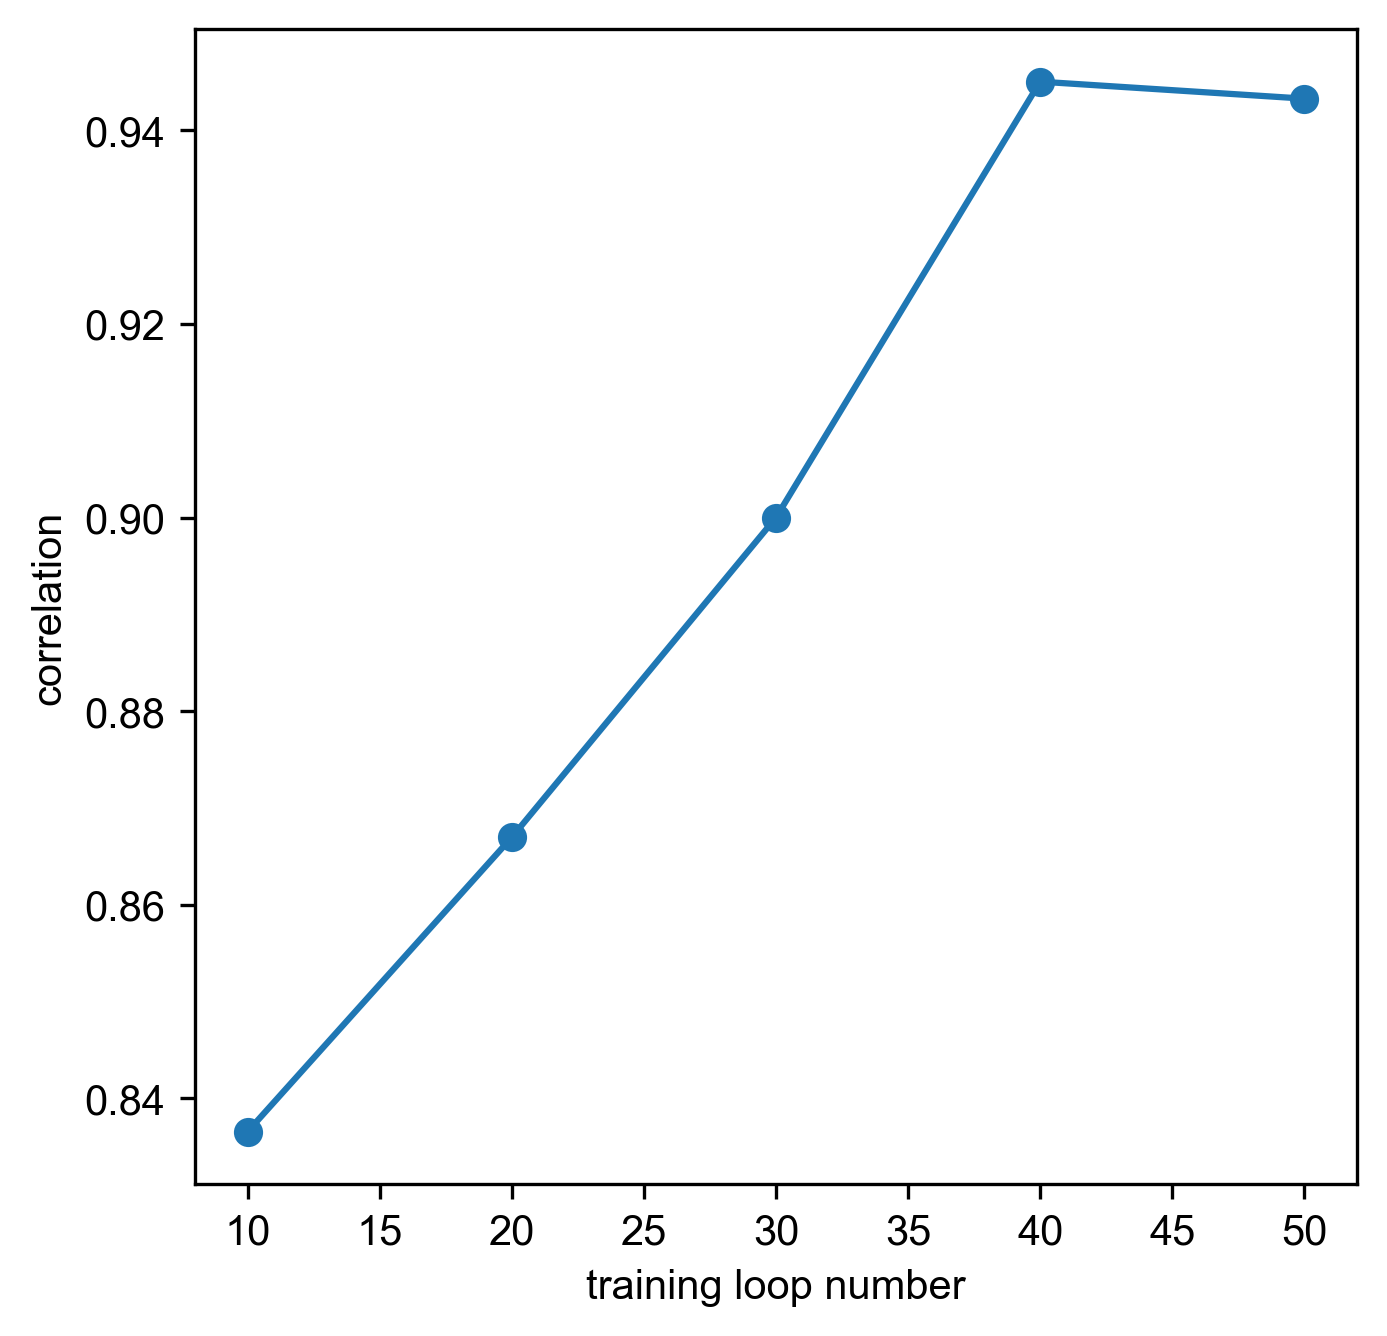

PyObject Text(0.5, 67.99999999999997, 'training loop number')

In [47]:
#Check correlation between xtarg and xtotal

iloop=50

loop_numbers = range(10, stop=iloop, step=10)
corr_vals=Float64[]

for l in 10:10:iloop
    filename = dirNetwork * "_performance_R_loop$(l).txt"
    corr = [parse(Float64, item) for item in readlines(filename)][1]
    push!(corr_vals, corr)

end

plot(loop_numbers, corr_vals,"-o")
ylabel("correlation")
xlabel("training loop number")


In [48]:
iloop=50
xtotal = load(dirNetwork * "xtotal_$(iloop).jld")["xtotal"]
xebal = load(dirNetwork * "xebal_$(iloop).jld")["xebal"]
xibal = load(dirNetwork * "xibal_$(iloop).jld")["xibal"]
xplastic = load(dirNetwork * "xplastic_$(iloop).jld")["xplastic"]
times = load(dirNetwork * "times_$(iloop).jld")["times"]
ns = load(dirNetwork * "ns_$(iloop).jld")["ns"];

[10010.0, 10210.0, 10410.0, 10610.0, 10810.0, 11010.0, 11210.0, 11410.0, 11610.0, 11810.0, 12010.0, 12210.0, 12410.0, 12610.0, 12810.0, 13010.0, 13210.0, 13410.0, 13610.0, 13810.0, 14010.0, 14210.0, 14410.0, 14610.0, 14810.0, 15010.0, 15210.0, 15410.0, 15610.0, 15810.0, 16010.0, 16210.0, 16410.0, 16610.0, 16810.0, 17010.0, 17210.0, 17410.0, 17610.0, 17810.0, 18010.0, 18210.0, 18410.0, 18610.0, 18810.0, 19010.0, 19210.0, 19410.0, 19610.0, 19810.0, 20010.0, 20210.0, 20410.0, 20610.0, 20810.0, 21010.0, 21210.0, 21410.0, 21610.0, 21810.0, 22010.0, 22210.0, 22410.0, 22610.0, 22810.0, 23010.0, 23210.0, 23410.0, 23610.0, 23810.0, 24010.0, 24210.0, 24410.0, 24610.0, 24810.0, 25010.0, 25210.0, 25410.0, 25610.0, 25810.0, 26010.0, 26210.0, 26410.0, 26610.0, 26810.0, 27010.0, 27210.0, 27410.0, 27610.0, 27810.0, 28010.0, 28210.0, 28410.0, 28610.0, 28810.0, 29010.0, 29210.0, 29410.0, 29610.0, 29810.0]

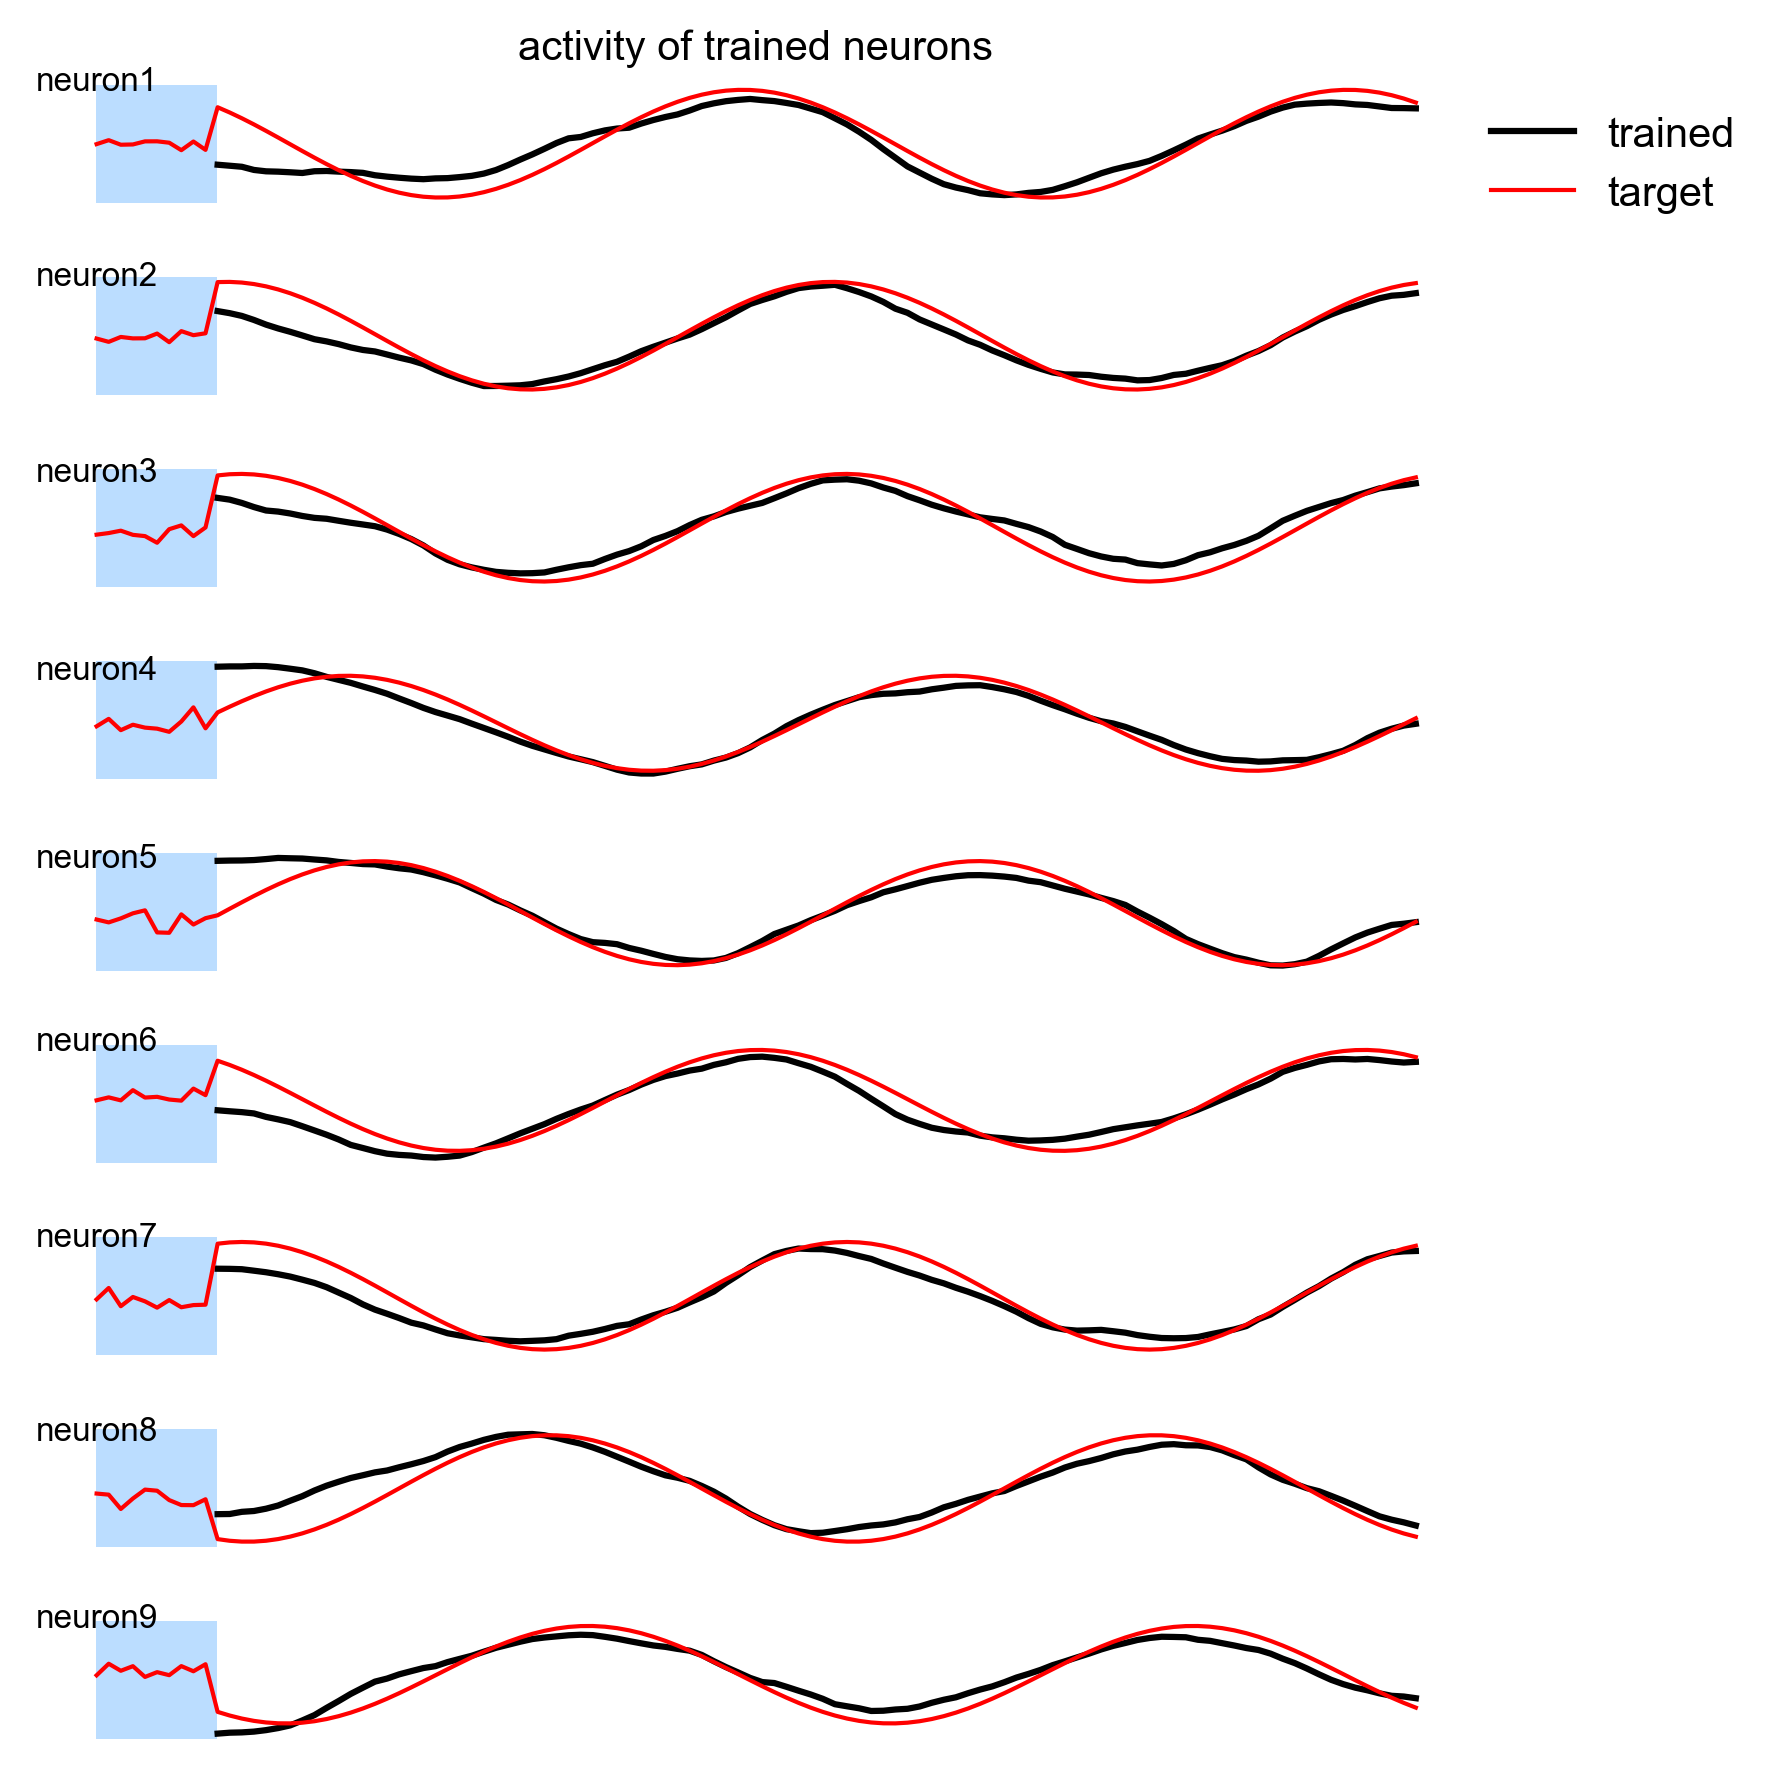

In [91]:
# compare synaptic activity and its target activity
tvec = collect((p.stim_off+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt)
ttarg = collect((p.stim_on+1)/p.dt:p.learn_every/p.dt:p.train_time/p.dt) #.+ 2000.0
print(tvec)

figure(figsize=(6,6))
for ci = 1:9
    subplot(9,1,ci)
    axvspan(p.stim_on/p.dt, p.stim_off/p.dt, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, xtotal[:,ci].+p.muemax, c="k", label = "trained")
    plot(ttarg, vcat(stim[1][1:Int(p.learn_every/p.dt):end,ci], xtarg[1][:,ci]), c="r", lw=1, label="target")
    annotate("neuron$(ci)", ((p.stim_on/p.dt)-1000,5), fontsize=8)
    
    if ci ==1
        title("activity of trained neurons")
        legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()

In [ ]:
#Get spike rates for each cell in the network 
include("src_balanced/spk2rate.jl")
spikes = spk2rate(p, matchedCells, times, ns);

for ci in matchedCells
    figure()
    plot(spikes[:,ci])
    xlabel("time")
    ylabel("firing rate (spk/s)")

LoadError: UndefVarError: `p` not defined